In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

Porcentaje de avance: 0.0%


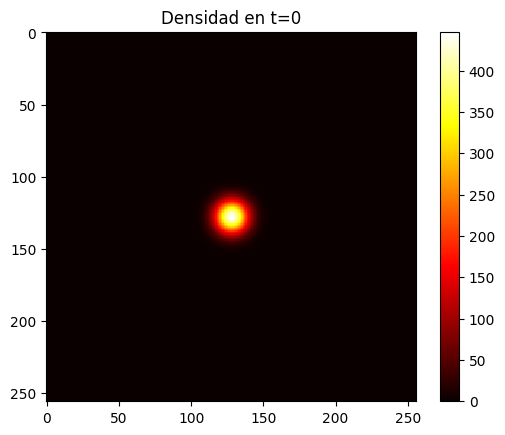

Porcentaje de avance: 1.0%


KeyboardInterrupt: 

In [21]:
# Constantes
Lx = 256
Ly = 256
Q = 9
W0 = 1.0 / 3.0
C = 0.5
C2 = C * C
Cs2 = C2 / 3.0
tau = 0.55
Utau = 1.0 / tau
UmUtau = 1.0 - Utau

# Pesos y vectores de velocidad
w = np.array([4.0 / 9.0] + [1.0 / 9.0] * 4 + [1.0 / 36.0] * 4)
Vx = np.array([0, 1, 0, -1, 0, 1, -1, -1, 1])
Vy = np.array([0, 0, 1, 0, -1, 1, 1, -1, -1])

# Inicialización de las funciones de distribución
f = np.zeros((Lx, Ly, Q))
fnew = np.zeros_like(f)

def rho(ix, iy, UseNew):
    return np.sum(fnew[ix, iy, :]) if UseNew else np.sum(f[ix, iy, :])

def Jx(ix, iy, UseNew):
    return np.sum(Vx * fnew[ix, iy, :]) if UseNew else np.sum(Vx * f[ix, iy, :])

def Jy(ix, iy, UseNew):
    return np.sum(Vy * fnew[ix, iy, :]) if UseNew else np.sum(Vy * f[ix, iy, :])


def feq(rho0, Ux0, Uy0, i):
    UdotVi = Ux0 * Vx[i] + Uy0 * Vy[i]
    U2 = Ux0**2 + Uy0**2
    return rho0 * w[i] * (1 + UdotVi / Cs2 + (UdotVi * UdotVi) / (2 * Cs2 * Cs2) - U2 / (2 * Cs2))


def Start(rho0, Ux0, Uy0, mu_x, mu_y, sigma_x, sigma_y):
    for ix in range(Lx):
        for iy in range(Ly):
            gauss_x = np.exp(-0.5 * ((ix - mu_x) / sigma_x) ** 2) / (sigma_x * np.sqrt(2 * np.pi))
            gauss_y = np.exp(-0.5 * ((iy - mu_y) / sigma_y) ** 2) / (sigma_y * np.sqrt(2 * np.pi))
            rho = rho0 * gauss_x * gauss_y
            for i in range(Q):
                f[ix, iy, i] = feq(rho, Ux0, Uy0, i)


def Collision():
    for ix in range(Lx):
        for iy in range(Ly):
            rho0 = rho(ix, iy, False)
            Ux0 = Jx(ix, iy, False) / rho0
            Uy0 = Jy(ix, iy, False) / rho0
            for i in range(Q):
                fnew[ix, iy, i] = UmUtau * f[ix, iy, i] + Utau * feq(rho0, Ux0, Uy0, i)


def ImposeFields(Ux0, Uy0):
    for ix in range(Lx):
        for iy in range(Ly):
            rho0 = rho(ix, iy, False)
            for i in range(Q):
                fnew[ix, iy, i] = feq(rho0, Ux0, Uy0, i)


def Advection():
    for ix in range(Lx):
        for iy in range(Ly):
            for i in range(Q):
                ix2 = (ix + Vx[i]) % Lx
                iy2 = (iy + Vy[i]) % Ly
                f[ix2, iy2, i] = fnew[ix, iy, i]

def Print(NameFile, t):
    with open(NameFile, 'w') as MyFile:
        for ix in range(0, Lx, 4):
            for iy in range(0, Ly, 4):
                rho0 = rho(ix, iy, True)
                MyFile.write(f"{ix} {iy} {rho0}\n")
            MyFile.write("\n")

def PlotDensity(t):
    density = np.zeros((Lx, Ly))
    for ix in range(Lx):
        for iy in range(Ly):
            density[ix, iy] = rho(ix, iy, True)
    plt.imshow(density.T, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(f"Densidad en t={t}")
    plt.show()

# Parámetros de la simulación
tmax = 100
tframe = 10
rho0 = 10000.0
Ux0 = 0.3
Uy0 = 0.3
mu_x = Lx / 2
mu_y = Ly / 2
sigma_x = Lx / 32
sigma_y = Ly / 32

# Iniciar la simulación
Start(rho0, Ux0, Uy0, mu_x, mu_y, sigma_x, sigma_y)

# Ejecutar la simulación
for t in range(tmax + 1):
    print(f"Porcentaje de avance: {(t * 100) / tmax}%")
    Collision()
    ImposeFields(Ux0, Uy0)
    Advection()
    if t % tframe == 0: # Imprimir cada 10 pasos de tiempo
        Print(f"data\density_{t}.dat", t)
        PlotDensity(t)

# Imprimir los resultados finales
Print("AdvectionDifusion.dat", t)
PlotDensity(t)

In [24]:
import os
import imageio

# Ruta de la carpeta de imágenes
folder_path = "frames/"

# Obtener la lista de archivos en la carpeta
file_list = os.listdir(folder_path)

# Filtrar solo los archivos de imagen
image_files = [file for file in file_list if file.endswith((".png", ".jpg", ".jpeg"))]

# Ordenar los archivos por nombre
image_files.sort()

# Crear una lista para almacenar las imágenes
images = []

# Leer cada imagen y agregarla a la lista
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    image = imageio.imread(image_path)
    images.append(image)

# Guardar el GIF
output_path = "AdvectionDifusion.gif"
imageio.mimsave(output_path, images, duration=25)

# Imprimir mensaje de éxito
print("GIF creado exitosamente en:", output_path)

ValueError: need at least one array to stack